In [44]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

from network import Network
from network import Trainer
from preprocessing import Preprocessing
from progressbar import ProgressBar

## Čišćenje dataSet-ova

In [2]:
preprocessing = Preprocessing()

In [3]:
# preprocessing.CheckImages("training/benign/")
# preprocessing.CheckImages("training/malignant/")

# preprocessing.CheckImages("validation/benign/")
# preprocessing.CheckImages("validation/malignant/")

# preprocessing.CheckImages("testing/benign/")
# preprocessing.CheckImages("testing/malignant/")

## Učitavanje podataka u vidu Tensora

In [4]:
trainingData = preprocessing.DataReader("training")
validationData = preprocessing.DataReader("validation")
testingData = preprocessing.DataReader("testing")

In [5]:
trainingIndicies = preprocessing.AppendIndicies(trainingData)
validationIndicies = preprocessing.AppendIndicies(validationData)
testingIndicies = preprocessing.AppendIndicies(testingData)

In [6]:
batchSize = 64

trainingDataLoader = preprocessing.DataLoader(
    trainingIndicies,
    trainingData,
    batchSize = batchSize)

validationDataLoader = preprocessing.DataLoader(
    validationIndicies,
    validationData,
    batchSize = batchSize)

testingDataLoader = preprocessing.DataLoader(
    testingIndicies,
    testingData,
    batchSize = batchSize)

## Prikaz slučajno izabranih snimaka iz sva tri dataSeta 
### Prva vizuelizacija je vizuelizacija dataSeta za trening, zatim slijedi validacioni dataSet i na kraju dataSet za testiranje

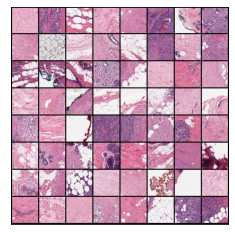

In [7]:
preprocessing.ShowGrid(trainingDataLoader)

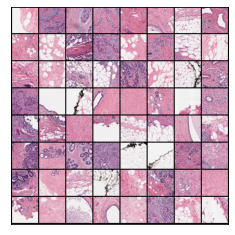

In [8]:
preprocessing.ShowGrid(validationDataLoader)

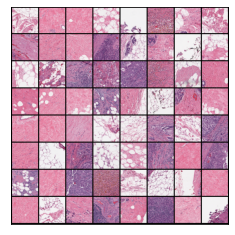

In [9]:
preprocessing.ShowGrid(testingDataLoader)

In [10]:
network = Network()
trainer = Trainer()

In [12]:
optimizer = optim.Adam(network.parameters(), lr = 0.001)
epochs = 5

avgEpochLoss, avgEpochAccuracy = [], []

for epoch in range(epochs):
    
    trainingLoss, trainingAccuracy = 0, 0 
    torch.set_grad_enabled(True)
    network.train()
                       
    loop = tqdm(enumerate(trainingDataLoader), total = len(trainingDataLoader), leave = False)
    for batchIndex, (images, labels) in loop:
        
        predictions = network(images)
        loss = F.cross_entropy(predictions, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        trainingLoss += loss.item()
        trainingAccuracy += trainer.Correct(predictions, labels)
        
        loop.set_description(f"Epoch [{epoch}/{epochs}]")
        loop.set_postfix(loss = loss.item(), acc = torch.rand(1).item())
        
    avgEpochLoss.append(trainingLoss/len(trainingData))
    avgEpochAccuracy.append(trainingAccuracy/len(trainingData))

In [15]:
epochs = 5

valEpochLoss, valEpochAccuracy = [], []
with torch.no_grad():

    for epoch in range(epochs):

        validationLoss, validationAccuracy = 0, 0 
        network.eval()

        loop = tqdm(enumerate(validationDataLoader), total = len(validationDataLoader), leave = False)
        for batchIndex, (images, labels) in loop:

            predictions = network(images)
            loss = F.cross_entropy(predictions, labels)            

            validationLoss += loss.item()
            validationAccuracy += trainer.Correct(predictions, labels)

            loop.set_description(f"Epoch [{epoch}/{epochs}]")
            loop.set_postfix(loss = loss.item(), acc = torch.rand(1).item())

        valEpochLoss.append(validationLoss/len(validationData))
        valEpochAccuracy.append(validationAccuracy/len(validationData))

In [28]:
# PATH = "./model/model.pth"
# torch.save(network.state_dict(), PATH)

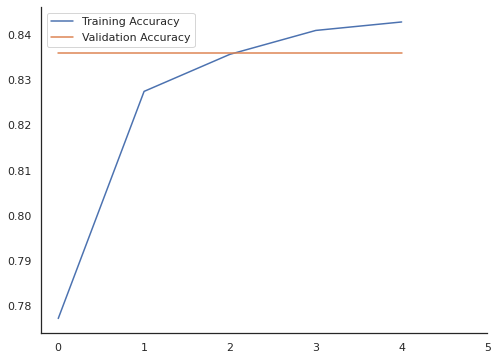

In [53]:
plt.figure(figsize = (8,6))
plt.plot(avgEpochAccuracy, label = "Training Accuracy")
plt.plot(valEpochAccuracy, label = "Validation Accuracy")
plt.xticks([0, 1, 2, 3, 4, 5])
plt.legend()

sns.set_style("white")
sns.despine(top = True, right = True)

plt.show()

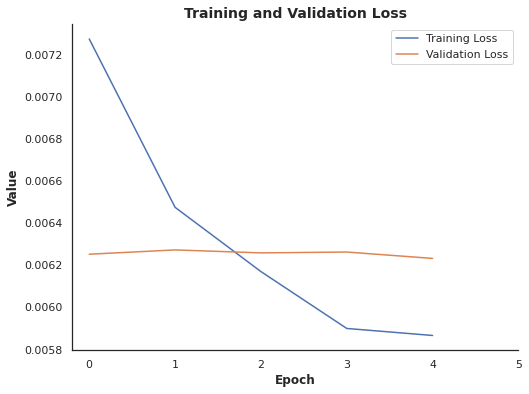

In [52]:
plt.figure(figsize = (8,6))
plt.plot(avgEpochLoss, label = "Training Loss")
plt.plot(valEpochLoss, label = "Validation Loss")
plt.title("Training and Validation Loss", fontsize = 14, fontweight = "bold")
plt.xlabel("Epoch", fontsize = 12, fontweight = "bold")
plt.ylabel("Value", fontsize = 12, fontweight = "bold")
plt.xticks([0, 1, 2, 3, 4, 5])

sns.set_style("white")
sns.despine(top = True, right = True)

plt.legend()
plt.show()